<p><img style="padding: 0 15px; float: left;" src="Images/FTLogo300.jpg" alt="FT Crusader Logo" Width='140' Height= '250'/></p> 
<p> <h2> Saint Paul 2019 City Council Election Voting Workbook; 07/31/19</h2> <a name="tc"></a>
<p> <h3> By Frogtown Crusader (Abu Nayeem)</h3>

***Disclaimer:*** Technically, the Minnesota voting data is not publicly accessible, but is publicly available. 

### Set-up/ Load Data

**Note:** I cannot provide the raw Election and Voting Records Data. The data steps follows similar to the initial 2015 results. In addition, I have added a few more new sections that were not available prior. 

In [53]:
# Import Packages
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline 
import requests # library to handle requests
import folium
import seaborn as sns
import scipy.stats as stats #used to get correlation coefficient

# Load 2019 Election Data
df_election1 = pd.read_csv('Election01.txt')
df_election2 = pd.read_csv('Election02.txt')
df_election3 = pd.read_csv('Election03.txt')
df_election4 = pd.read_csv('Election04.txt')
df_election5 = pd.read_csv('Election05.txt')
df_election6 = pd.read_csv('Election06.txt')
df_election7 = pd.read_csv('Election07.txt')
df_election8 = pd.read_csv('Election08.txt')

#Combine Election the data
df_election_hal1= pd.concat([df_election1,df_election2,df_election3,df_election4])
df_election_hal2= pd.concat([df_election5,df_election6,df_election7,df_election8])

#Load Voter Data
#df_voter1 = pd.read_csv('Voter01.txt')
#df_voter2 = pd.read_csv('Voter02.txt')
#df_voter3 = pd.read_csv('Voter03.txt') -bugged
df_voter4 = pd.read_csv('Voter04.txt') #had desired county code: Saint Paul/ 
df_voter5 = pd.read_csv('Voter05.txt') #had desired county code: Saint Paul/ Minneapolis
#df_voter6 = pd.read_csv('Voter06.txt') -bugged
#df_voter7 = pd.read_csv('Voter07.txt')
#df_voter8 = pd.read_csv('Voter08.txt') -bugged

#Combine Voter Data
df_voter= pd.concat([df_voter4, df_voter5])

#Saint Paul Data
sp_voter= df_voter.query("City== 'ST PAUL'") #Only city of Saint Paul

#Minneapolis data
#minn_voter= df_voter5.query("City== 'MINNEAPOLIS'")


In [ ]:
#Prepare Voter Data

# fix up Voter Data

#Prep Stuff
sp_voter['ZipCode']= sp_voter['ZipCode'].str[:5]  #first 5 digits of zipcode
sp_voter['PhoneNumber']= sp_voter['PhoneNumber'].str[:3] + '-' + sp_voter['PhoneNumber'].str[3:6] + '-' + sp_voter['PhoneNumber'].str[6:10]
sp_voter['Age'] = 2019 - sp_voter['DOBYear'] 

#Prepare long address
sp_voter['Temp']= sp_voter.HouseNumber + ' '+ sp_voter.StreetName+ ', '
sp_voter['Temp']=sp_voter['Temp'].str.replace(" ,", ",")
sp_voter['Address']=sp_voter.Temp + sp_voter.City+ ', ' + sp_voter.State+ ', ' + sp_voter.ZipCode
sp_voter['Age'] = 2019 - sp_voter['DOBYear'] 

def RegistrationPeriod(x): 
    if x in ['2018-11-06 00:00:00','2016-11-08 00:00:00','2017-11-07 00:00:00','2015-11-06 00:00:00']:
        return 'Election'
    elif x in ['2018-08-14 00:00:00','2019-06-05 00:00:00','2017-04-26 00:00:00']:
        return 'Primary'
    else:
        return 'Other'

sp_voter['RegistrationDay']= sp_voter['RegistrationDate'].apply(RegistrationPeriod)
sp_voter['RegistrationYear']= sp_voter['RegistrationDate'].str[:4]  #first 5 digits of zipcode

sp_voter.RegistrationYear = sp_voter.RegistrationYear.astype(int) #convert to integer

sp_voter['RegistrationDiff']= 2019- sp_voter['RegistrationYear']
  
    
#Prepare Full name
sp_voter['FullName']= sp_voter.FirstName.str.title() + ' ' + sp_voter.LastName.str.title()

sp_voter=sp_voter.reset_index()



### Voter Registration Analysis



In [8]:
#Load the old data from 06/23/19

df_voter4 = pd.read_csv('OldVoter/Voter04.txt') #had desired county code: Saint Paul/ 
df_voter5 = pd.read_csv('OldVoter/Voter05.txt') #had desired county code: Saint Paul/ Minneapolis

#Combine Voter Data
df_voter= pd.concat([df_voter4, df_voter5])

#Saint Paul Data
sp_oldvoter= df_voter.query("City== 'ST PAUL'") #Only city of Saint Paul
sp_oldvoter['Age'] = 2019 - sp_oldvoter['DOBYear'] 


In [4]:
minn_voter= df_voter5.query("City== 'MINNEAPOLIS'")

#### Create Registered Voter Distribution

In [3]:
#View Columns
sp_voter.columns

Index(['VoterId', 'CountyCode', 'FirstName', 'MiddleName', 'LastName',
       'NameSuffix', 'HouseNumber', 'StreetName', 'UnitType', 'UnitNumber',
       'Address2', 'City', 'State', 'ZipCode', 'MailAddress', 'MailCity',
       'MailState', 'MailZipCode', 'PhoneNumber', 'RegistrationDate',
       'DOBYear', 'StateMcdCode', 'McdName', 'PrecinctCode', 'PrecinctName',
       'WardCode', 'School', 'SchSub', 'Judicial', 'Legislative', 'StateSen',
       'Congressional', 'Commissioner', 'Park', 'SoilWater', 'Hospital',
       'LegacyId'],
      dtype='object')

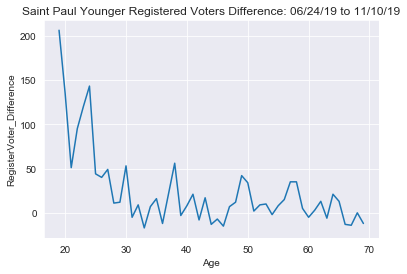

In [476]:
#Prep
sp_voter['Counting'] = 1 
sp_oldvoter['Counting'] = 1 

# Aggregate by Age
Features= ['Age','Counting']
age_voter= sp_voter[Features].groupby(['Age']).sum()
age_oldvoter= sp_oldvoter[Features].groupby(['Age']).sum()

#Combine the two tables with changing column names
age_voter=age_voter.reset_index()
age_oldvoter=age_oldvoter.reset_index()
age_oldvoter.columns= ["Age","Initial"]
age_oldvoter=age_oldvoter.set_index('Age').join(age_voter.set_index('Age'))
age_oldvoter['RegisterVoter_Difference']= age_oldvoter.Counting-age_oldvoter.Initial
age_oldvoter=age_oldvoter.reset_index()

#Graph the younger population
ax = sns.lineplot(x="Age", y="RegisterVoter_Difference", data=age_oldvoter.query('Age>18 and Age<70'))
ax.set_title('Saint Paul Younger Registered Voters Difference: 06/24/19 to 11/10/19')

#Save Graph
figure = ax.get_figure()    
figure.savefig('RegisterVoterDifferenceYoung.png', dpi=400)




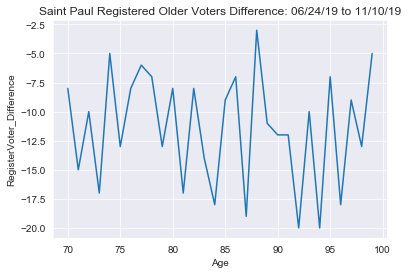

In [477]:
#Graph 

ax = sns.lineplot(x="Age", y="RegisterVoter_Difference", data=age_oldvoter.query('Age>69 and Age< 100'))
ax.set_title('Saint Paul Registered Older Voters Difference: 06/24/19 to 11/10/19')

#Save Graph
figure = ax.get_figure()    
figure.savefig('RegisterVoterDifferenceOld.png', dpi=400)


In [374]:
# Registry difference by ward 
Features= ['WardCode','Counting']
age_voter= sp_voter[Features].groupby(['WardCode']).sum()
age_oldvoter= sp_oldvoter[Features].groupby(['WardCode']).sum()


#Create single table
age_voter=age_voter.reset_index()
age_oldvoter=age_oldvoter.reset_index()
age_oldvoter.columns= ["Ward","PreElection_06/24/19"]
age_oldvoter=age_oldvoter.set_index('Ward').join(age_voter.set_index('WardCode'))
age_oldvoter['RegisterVoter_Difference']= age_oldvoter.Counting-age_oldvoter['PreElection_06/24/19']
age_oldvoter=age_oldvoter.reset_index()
age_oldvoter.columns= ["Ward","PreElection_06/24/19","PostElection_11/10/19", 'RegisterVoter_Difference']
#age_oldvoter
age_oldvoter


,Ward,PreElection_06/24/19,PostElection_11/10/19,RegisterVoter_Difference
0,1.0,21699,22086,387
1,2.0,26735,27144,409
2,3.0,29145,29121,-24
3,4.0,26475,26259,-216
4,5.0,19933,20298,365
5,6.0,19431,19895,464
6,7.0,20584,20810,226


### Prep Election Records

I choose to work with smaller column dataset first computation will increase for larger dataset and election dataset needs to be condensed to a single line to be more easily accessible.

In [54]:
#Get the "Year" variable from election date. 
#NOTE: My normal method to converting datetime was too computational for my computer to handle. I commented it out

#df_election_all['DateTime']= pd.to_datetime(df_election_all['ElectionDate']) # Create new column called DateTime
#df_election_all['Year']= df_election_all['DateTime'].dt.year #create year column

df_election_hal1['Year'] = df_election_hal1['ElectionDate'].str.strip().str[6:]
df_election_hal1.Year = df_election_hal1.Year.astype(int) #convert to integer
df_election_hal1= df_election_hal1.query('Year in (2015,2017,2018,2019)')

In [55]:
df_election_hal2['Year'] = df_election_hal2['ElectionDate'].str.strip().str[6:]
df_election_hal2.Year = df_election_hal2.Year.astype(int) #convert to integer
df_election_hal2= df_election_hal2.query('Year in (2015,2017,2018,2019)')

In [56]:
#COmbine
df_election_all= pd.concat([df_election_hal1, df_election_hal2])

In [57]:
#select primary key from Voter table
Voter_ID= sp_voter.iloc[:,[0,1]]

#Specify Primary Key and keep only the matches
df_SP_raw=df_election_all.set_index('VoterId').join(Voter_ID.set_index('VoterId'))

In [185]:
# Testing Event Values
#df_SP_raw.query("Year==2019")['ElectionDescription'].value_counts()
#Ward1_15['ElectionDescription'].value_counts()
#'11/05/2019 - SCHOOL DISTRICT GENERAL', '11/05/2019 - SPEC ELECT RAMSEY CO COM 01'  

In [354]:
# I already selected the events I'm interested
df_SP= df_SP_raw.query('ElectionDescription in ("11/07/2017 - MUNICIPAL GENERAL","11/03/2015 - MUNICIPAL GENERAL","11/05/2019 - MUNICIPAL GENERAL","11/06/2018 - STATE GENERAL","11/05/2019 - SCHOOL DISTRICT GENERAL", "11/05/2019 - SPEC ELECT RAMSEY CO COM 01" )')

#Create Variables
df_SP['SP_Vote15'] = df_SP['ElectionDescription'].apply(lambda x: 1 if (x=='11/03/2015 - MUNICIPAL GENERAL')  else 0)
df_SP['SP_Vote17'] = df_SP['ElectionDescription'].apply(lambda x: 1 if (x=='11/07/2017 - MUNICIPAL GENERAL')  else 0)
df_SP['SP_Vote18'] = df_SP['ElectionDescription'].apply(lambda x: 1 if (x=='11/06/2018 - STATE GENERAL')  else 0)
df_SP['SP_Vote19'] = df_SP['ElectionDescription'].apply(lambda x: 1 if (x=="11/05/2019 - MUNICIPAL GENERAL")  else 0)

#Aggregate the data by Voter
Features= ['SP_Vote15','SP_Vote17','SP_Vote18','SP_Vote19']
df_SP= df_SP[Features].groupby(['VoterId']).sum()

#Add additional variables
df_SP['Vote_Senate']= df_SP['SP_Vote19']  + df_SP['SP_Vote18']
df_SP['Vote_Mayor']= df_SP['SP_Vote19']  + df_SP['SP_Vote17']
df_SP['Vote_City']= df_SP['SP_Vote19']  + df_SP['SP_Vote15']

df_SP['Vote_Mayor'] = df_SP['Vote_Mayor'].apply(lambda x: 1 if (x==2)  else 0)
df_SP['Vote_Senate'] = df_SP['Vote_Senate'].apply(lambda x: 1 if (x==2) else 0)
df_SP['Vote_City'] = df_SP['Vote_City'].apply(lambda x: 1 if (x==2)  else 0)

#Combine with voter data
df_SP=df_SP.reset_index()
com_SP=sp_voter.set_index('VoterId').join(df_SP.set_index('VoterId'))
com_SP=com_SP.reset_index()

#Correct the Precinct Name File so connect with JSON file for Mapping
com_SP.PrecinctName=com_SP.PrecinctName.str.replace('ST. PAUL', 'Saint Paul')
com_SP.PrecinctName=com_SP.PrecinctName.str.replace('-0', '-')

#Etymology DataBase

# Export csv of lastnames with count greater than 25
com_SP['Counting']= 1
Features= ['LastName','Counting']
Names= com_SP[Features].groupby(['LastName']).sum()
Names=Names.reset_index()
Names= Names.query('Counting>25')
Names.to_csv(r'LastNames.csv',index=False)

# Export csv of firstnames with count greater than 50
com_SP['Counting']= 1
Features= ['FirstName','Counting']
Names= com_SP[Features].groupby(['FirstName']).sum()
Names=Names.reset_index()
Names= Names.query('Counting>50')
Names.to_csv(r'FirstNames.csv',index=False)

# Loading the final Database
lastname= pd.read_csv('ClassLastNames.csv')
Features= ['LastName', 'Etymology_Surname_Category']
lastname= lastname[Features]
lastname.columns= ['LastName', 'Ety_Category']


#Specify Primary Key and keep only the matches
com_SP=com_SP.set_index('LastName').join(lastname.set_index('LastName'))
com_SP['Ety_Category'].fillna("Insufficent_Number", inplace=True)
com_SP=com_SP.reset_index()

# Save the CSV of the final file
com_SP.to_csv(r'SP2019Base.csv',index=False)


#### Plot Voting Trends

#### Multiple Saint Paul Races

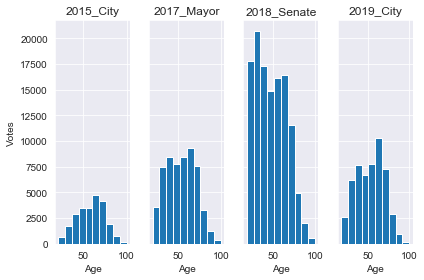

In [378]:
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

#com_SP['Age'] = 2019 - com_SP['DOBYear'] 
#com_Mpls['Age'] = 2019 - com_Mpls['DOBYear'] 


fig, axs = plt.subplots(1, 4, sharey=True, tight_layout=True)

# We can set the number of bins with the `bins` kwarg
#axs[0].hist(com_Ward1['Age'], bins=20)
axs[0].set_ylabel('Votes')
axs[0].set_xlabel('Age')
axs[1].set_xlabel('Age')
axs[2].set_xlabel('Age')
axs[3].set_xlabel('Age')


axs[0].hist(com_SP.query('SP_Vote15>0 and Age<101').Age, bins=10)
axs[1].hist(com_SP.query('SP_Vote17>0 and Age<101').Age, bins=10)
axs[2].hist(com_SP.query('SP_Vote18>0 and Age<101').Age, bins=10)
axs[3].hist(com_SP.query('SP_Vote19>0 and Age<101').Age, bins=10)


axs[0].set_title('2015_City')
axs[1].set_title('2017_Mayor')
axs[2].set_title('2018_Senate')
axs[3].set_title('2019_City')


figure = fig.get_figure()    
fig.savefig('ElectionVoteCount.png', dpi=400)

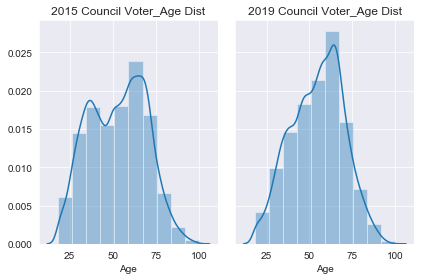

In [380]:
import matplotlib.pyplot as plt
from pylab import savefig

#Correcting for Age
Features1= ['Age','SP_Vote19']
Features= ['Age','SP_Vote15']

m=com_SP[Features1]
s=com_SP[Features]
s['Age']= s['Age'] -4

#Graphing
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

bg= sns.distplot(s.query('SP_Vote15>0 and Age<101').Age, bins=10, ax=axs[1], axlabel=False)
sns.distplot(m.query('SP_Vote19>0 and Age<101').Age, bins=10, ax=axs[0], axlabel=False)


#bg= sns.distplot(com_Mpls.query('Mpls_Vote17>0').Age, bins=10, ax=ax1, axlabel=False)#, kde=False)

axs[0].set_title('2015 Council Voter_Age Dist')
axs[1].set_title('2019 Council Voter_Age Dist')

axs[0].set_xlabel('Age')
axs[1].set_xlabel('Age')

#com_Mpls.Age.value_counts()

figure = bg.get_figure()    
figure.savefig('Saint_Paul_Voter_Age_Distribution.png', dpi=400)

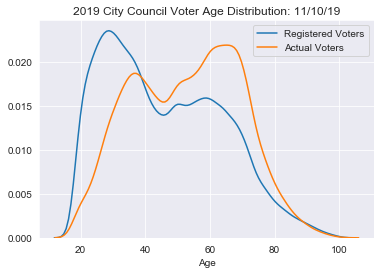

In [388]:
#Create Intro Graphs

import matplotlib.pyplot as plt
from pylab import savefig

#Correcting for Age
Features1= ['Age','SP_Vote19']
s=com_SP[Features1]

#Graphing

ax=sns.kdeplot(sp_voter.query('Age<101').Age, label='Registered Voters')
sns.distplot(s.query('SP_Vote19>0 and Age<101').Age, bins=10, label='Actual Voters', hist=False)

ax.set_title('2019 City Council Voter Age Distribution: 11/10/19')
ax.set(xlabel='Age')

figure = ax.get_figure()    
figure.savefig('CityCouncilAgeDistribution.png', dpi=400)

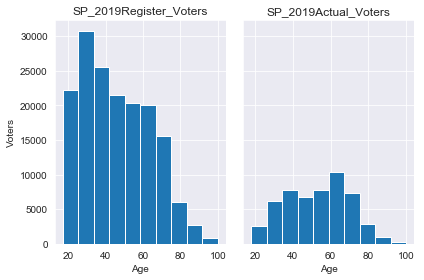

In [389]:
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

#com_SP['Age'] = 2019 - com_SP['DOBYear'] 
#com_Mpls['Age'] = 2019 - com_Mpls['DOBYear'] 


fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)


# We can set the number of bins with the `bins` kwarg
#axs[0].hist(com_Ward1['Age'], bins=20)
axs[0].set_ylabel('Voters')

axs[0].hist(sp_voter.query('Age<101').Age, bins=10)
axs[1].hist(com_SP.query('SP_Vote19>0 and Age<101').Age, bins=10)

axs[0].set_xlabel('Age')
axs[1].set_xlabel('Age')

axs[0].set_title('SP_2019Register_Voters')
axs[1].set_title('SP_2019Actual_Voters')

figure = bg.get_figure()    
figure.savefig('CityCouncilBar_VoterAge_Distribution.png', dpi=400)

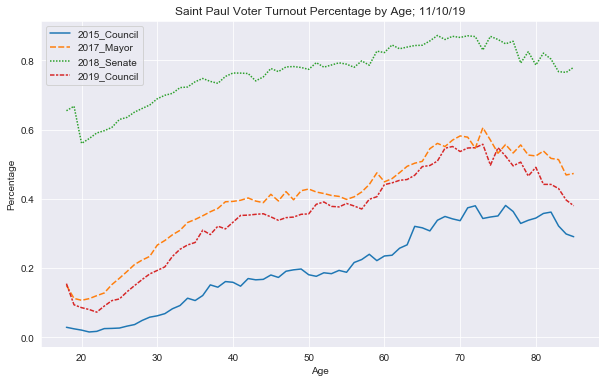

In [220]:
com_SP['Counting']=1
#com_Mpls['Counting']=1

Features= ['Age','SP_Vote15','Counting']
SP_15= com_SP[Features].groupby(['Age']).sum()
SP_15['2015_Council'] = SP_15.SP_Vote15 / SP_15.Counting
SP_15=SP_15.reset_index()
SP_15['Age']= SP_15['Age'] -4 
SP_15= SP_15.query('Age<86 and Age>17')
f= ['Age','2015_Council']
SP_15= SP_15[f]


Features= ['Age','SP_Vote17','Counting']
SP_17= com_SP[Features].groupby(['Age']).sum()
SP_17['2017_Mayor'] = SP_17.SP_Vote17 / SP_17.Counting
SP_17=SP_17.reset_index()
SP_17['Age']= SP_17['Age'] -2 
SP_17= SP_17.query('Age<86 and Age>17')
f= ['Age','2017_Mayor']
SP_17= SP_17[f]

Features= ['Age','SP_Vote18','Counting']
SP_18= com_SP[Features].groupby(['Age']).sum()
SP_18['2018_Senate'] = SP_18.SP_Vote18 / SP_18.Counting
SP_18=SP_18.reset_index()
SP_18['Age']= SP_18['Age'] -1
SP_18= SP_18.query('Age<86 and Age>17')
f= ['Age','2018_Senate']
SP_18= SP_18[f]

#SaintPaul
Features= ['Age','SP_Vote19','Counting']
SP_19= com_SP[Features].groupby(['Age']).sum()
SP_19['2019_Council'] = SP_19.SP_Vote19 / SP_19.Counting
SP_19=SP_19.reset_index()
SP_19= SP_19.query('Age<86 and Age>17')
f= ['Age','2019_Council']
SP_19= SP_19[f]

# Create Single Table
a=SP_15.set_index('Age').join(SP_17.set_index('Age'))
a=a.reset_index()
b=a.set_index('Age').join(SP_18.set_index('Age'))
b=b.reset_index()
c=b.set_index('Age').join(SP_19.set_index('Age'))


# Set the width and height of the figure
plt.figure(figsize=(10,6))

# Add title
plt.title("Saint Paul Voter Turnout Percentage by Age; 11/10/19")

col= ['2015_Council', '2017_Mayor','2018_Senate', '2019_Council']

bg=sns.lineplot(data=c[col])

# Add label for horizontal axis
plt.xlabel("Age")
plt.ylabel("Percentage")

figure = bg.get_figure() 
figure.savefig('VoterTurnoutPercentage.png', dpi=400)


### Etymology Charts

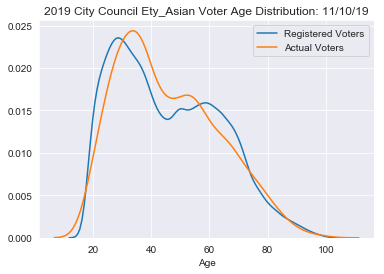

In [393]:
#Create Intro Graphs

import matplotlib.pyplot as plt
from pylab import savefig

#Correcting for Age
Features1= ['Age','SP_Vote19','Ety_Category']
s=com_SP[Features1].query('Ety_Category =="East/SouthEast_Asian"')


ax=sns.kdeplot(sp_voter.query('Age<101').Age, label='Registered Voters')
sns.distplot(s.query('SP_Vote19>0 and Age<101').Age, bins=10, label='Actual Voters', hist=False)

ax.set_title('2019 City Council Ety_Asian Voter Age Distribution: 11/10/19')
ax.set(xlabel='Age')

figure = ax.get_figure()    
figure.savefig('CityCouncil_EtyAsian_AgeDistribution.png', dpi=400)

[Text(0.5, 0, 'Age')]

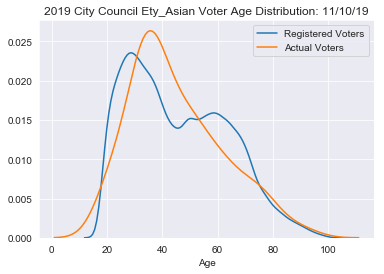

In [396]:
#Create Intro Graphs

import matplotlib.pyplot as plt
from pylab import savefig

#Correcting for Age
Features1= ['Age','SP_Vote19','Ety_Category']
s=com_SP[Features1].query('Ety_Category =="Arabic_Islam"')


ax=sns.kdeplot(sp_voter.query('Age<101').Age, label='Registered Voters')
sns.distplot(s.query('SP_Vote19>0 and Age<101').Age, bins=10, label='Actual Voters', hist=False)

ax.set_title('2019 City Council Ety_Arabic Voter Age Distribution: 11/10/19')
ax.set(xlabel='Age')

#figure = ax.get_figure()    
#figure.savefig('CityCouncil_EtyAsian_AgeDistribution.png', dpi=400)

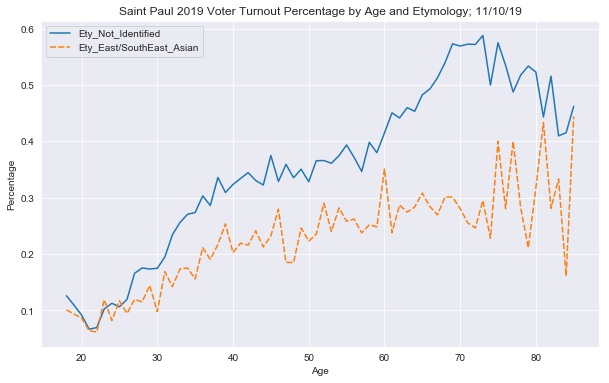

In [224]:
Features= ['Age','SP_Vote19','Counting','Ety_Category']
A= com_SP[Features].query('Age<86 and Age>17 and Ety_Category =="East/SouthEast_Asian"')
N= com_SP[Features].query('Age<86 and Age>17 and Ety_Category =="Not_identified"')
N=N.groupby(['Age']).sum()
A=A.groupby(['Age']).sum()
N=N.reset_index()
A=A.reset_index()

A['Ety_East/SouthEast_Asian'] = A.SP_Vote19 / A.Counting
f= ['Age','Ety_East/SouthEast_Asian']
A= A[f]
N['Ety_Not_Identified'] = N.SP_Vote19 / N.Counting
f= ['Age','Ety_Not_Identified']
N= N[f]

B=N.set_index('Age').join(A.set_index('Age'))
#B=B.reset_index()

# Set the width and height of the figure
plt.figure(figsize=(10,6))

# Add title
plt.title("Saint Paul 2019 Voter Turnout Percentage by Age and Etymology; 11/10/19")

col= ['Ety_Not_Identified','Ety_East/SouthEast_Asian']

bg=sns.lineplot(data=B[col])

# Add label for horizontal axis
plt.xlabel("Age")
plt.ylabel("Percentage")

figure = bg.get_figure() 
figure.savefig('EtyVoterTurnoutPercentage.png', dpi=400)

### Ward/Young Voter Data

In [404]:
# 2019 Saint Paul City Council Numbers Setup

com_SP['Counting']=1

#Setup For all Age
Features= ['Age','WardCode','SP_Vote19','Counting']
E_19= com_SP[Features].groupby(['WardCode','Age']).sum()
E_19=E_19.reset_index()
E_19= E_19.query('Age>17')
E_19_All= E_19.groupby(['WardCode']).sum()
E_19_All['Vote%'] = round(E_19_All.SP_Vote19 / E_19_All.Counting, 4) *100
E_19_All.drop(['Age'], axis=1, inplace=True)
E_19_All.columns= ['Total_Votes','Total_Registered','Total_Voting%']
E_19_All=E_19_All.reset_index()


#Setup for youth [18-20]
E_19_Young= E_19.query('Age<21')
E_19_Young= E_19_Young.groupby(['WardCode']).sum()
E_19_Young['YouthVote%'] = round(E_19_Young.SP_Vote19 / E_19_Young.Counting, 4) *100
E_19_Young.drop(['Age'], axis=1, inplace=True)
E_19_Young.columns= ['Youth_Votes','Youth_Registered','Youth_Voting%']
E_19_Young=E_19_Young.reset_index()
E_19_Young['YouthVote%_by_Total']= round(E_19_Young.Youth_Votes/ E_19_All.Total_Votes, 4) *100 

E_19_All=E_19_All.set_index('WardCode').join(E_19_Young.set_index('WardCode'))

#Total Column

Features= ['Age','SP_Vote19','Counting']
El= com_SP[Features].groupby(['Age']).sum()
El=El.reset_index()
El= El.query('Age>17')
El['WardCode']= 'All'
Ela= El.groupby(['WardCode']).sum()
Ela['Vote%'] = round(Ela.SP_Vote19 / Ela.Counting, 4) *100
Ela.drop(['Age'], axis=1, inplace=True)
Ela.columns= ['Total_Votes','Total_Registered','Total_Voting%']
Ela=Ela.reset_index()
Ela

Ely= El.query('Age<21')
Ely= Ely.groupby(['WardCode']).sum()
Ely['Vote%'] = round(Ely.SP_Vote19 / Ely.Counting, 4) *100
Ely.drop(['Age'], axis=1, inplace=True)
Ely.columns= ['Youth_Votes','Youth_Registered','Youth_Voting%']
Ely=Ely.reset_index()
Ely['YouthVote%_by_Total']= round(Ely.Youth_Votes/ Ela.Total_Votes, 4) *100 
Ely

b=Ela.set_index('WardCode').join(Ely.set_index('WardCode'))

#Final Table
Fin=E_19_All.append(b)
E_19_All= E_19_All.reset_index()

Fin= Fin.reset_index()

#save table
Fin.to_csv(r'2019_YouthVoting.csv',index=False)

Fin


,WardCode,Total_Votes,Total_Registered,Total_Voting%,Youth_Votes,Youth_Registered,Youth_Voting%,YouthVote%_by_Total
0,1,6534.0,22081,29.59,69.0,709,9.73,1.06
1,2,7780.0,27141,28.67,52.0,572,9.09,0.67
2,3,12450.0,29113,42.76,183.0,1243,14.72,1.47
3,4,9815.0,26257,37.38,100.0,1179,8.48,1.02
4,5,5834.0,20295,28.75,59.0,675,8.74,1.01
5,6,5513.0,19893,27.71,67.0,731,9.17,1.22
6,7,4718.0,20807,22.68,48.0,665,7.22,1.02
7,All,52644.0,165587,31.79,578.0,5774,10.01,1.10


### Aggregation Info

#### Precinct Aggregation

In [386]:
#EERRRROOR
#com_SP#.columns
df_SP.query('VoterId==2124280')
sp_voter.query('VoterId==2124280')
df_SP_raw.query('VoterId==2212404')
#ElectionVote4text
#com_SP.query('LastName=="REPKE"')
#139


,ElectionDate,ElectionDescription,VotingMethod,Year,CountyCode
VoterId,,,,,
2212404,11/03/2015,11/03/2015 - MUNICIPAL GENERAL,P,2015,62.0
2212404,11/07/2017,11/07/2017 - MUNICIPAL GENERAL,P,2017,62.0
2212404,08/14/2018,08/14/2018 - STATE PRIMARY,P,2018,62.0
2212404,11/06/2018,11/06/2018 - STATE GENERAL,P,2018,62.0


In [482]:
Features= ['WardCode','PrecinctName', 'SP_Vote19','SP_Vote15','Vote_Mayor', 'Vote_City', 'Vote_Senate','Counting']
P_15= com_SP[Features].groupby(['WardCode']).sum()
P_15

,SP_Vote19,SP_Vote15,Vote_Mayor,Vote_City,Vote_Senate,Counting
WardCode,,,,,,
1.0,6537.0,2614.0,4539.0,2029.0,6136.0,22086
2.0,7782.0,4782.0,5348.0,3344.0,7460.0,27144
3.0,12455.0,4872.0,9585.0,3968.0,12087.0,29121
4.0,9817.0,4804.0,7543.0,3961.0,9532.0,26259
5.0,5835.0,3337.0,3866.0,2513.0,5523.0,20298
6.0,5514.0,1884.0,3269.0,1424.0,4934.0,19895
7.0,4720.0,1726.0,2895.0,1270.0,4438.0,20810


In [484]:
com_SP['Counting']=1

#Setup For Normal Voting 
Features= ['WardCode','PrecinctName', 'SP_Vote19','Vote_Mayor', 'Vote_City', 'Vote_Senate','Counting']
P_19= com_SP[Features].groupby(['WardCode','PrecinctName']).sum()
P_19=P_19.reset_index()

#Setup for Addresses
Features= ['WardCode','PrecinctName','Address','Counting','SP_Vote19']
Den= com_SP[Features]
b= Den.groupby(['WardCode','PrecinctName','Address']).sum()
b= b.reset_index()

H_den=b.query('Counting>39')
L_den=b.query('Counting<40')


#Precinct Density

HP_den= H_den.groupby(['PrecinctName']).sum()
HP_den= HP_den.reset_index()
HP_den.drop(['WardCode'], axis=1, inplace=True)
HP_den['H_Density_Vote%']= round(HP_den.SP_Vote19 / HP_den.Counting, 4) *100
HP_den.columns=['PrecinctName', 'H_Registered', 'H_Vote19','H_Density_Vote%']
HP_den

LP_den= L_den.groupby(['PrecinctName']).sum()
LP_den= LP_den.reset_index()
LP_den.drop(['WardCode'], axis=1, inplace=True)
LP_den['L_Density_Vote%']= round(LP_den.SP_Vote19 / LP_den.Counting, 4) *100
LP_den.columns=['PrecinctName', 'L_Registered', 'L_Vote19','L_Density_Vote%']
LP_den


#Merge Aggregate Data

Pre19= pd.read_csv('SP2019PrecinctBase.csv')
Ward19= pd.read_csv('SP2019WardBase.csv')
Pre19=Pre19.set_index('Precinct').join(P_19.set_index('PrecinctName'))
Pre19=Pre19.reset_index()
Pre19=Pre19.set_index('Precinct').join(HP_den.set_index('PrecinctName'))
Pre19=Pre19.reset_index()
Pre19['H_Registered'].fillna(0, inplace=True)
Pre19['H_Vote19'].fillna(0, inplace=True)
Pre19['H_Density_Vote%'].fillna(0, inplace=True)
Pre19=Pre19.set_index('Precinct').join(LP_den.set_index('PrecinctName'))
Pre19=Pre19.reset_index()
Pre19['L_Registered'].fillna(0, inplace=True)
Pre19['L_Vote19'].fillna(0, inplace=True)
Pre19['L_Density_Vote%'].fillna(0, inplace=True)

#Create new columns
Pre19['H_Density%']= round(Pre19.H_Registered / (Pre19.H_Registered + Pre19.L_Registered) , 4) *100
Pre19['Vote_Mayor%']= round(Pre19.Vote_Mayor / (Pre19.SP_Vote19) , 4) *100
Pre19['Vote_LastCity%']= round(Pre19.Vote_City / (Pre19.SP_Vote19) , 4) *100
Pre19['Vote_Senate%']= round(Pre19.Vote_Senate / (Pre19.SP_Vote19) , 4) *100
Pre19['Density_VoteDiff%']= Pre19['L_Density_Vote%']- Pre19['H_Density_Vote%']

Pre19.to_csv(r'2019Precinct_Complete.csv',index=False)

Pre19

,Precinct,Ward,Precinct1,Reg_Vote_11/7/19,Total_Vote,Early/Abs_Vote%,LastCouncil_Vote%,Tot_Vote%,1st_Undervote%,Representation,...,H_Vote19,H_Density_Vote%,L_Registered,L_Vote19,L_Density_Vote%,H_Density%,Vote_Mayor%,Vote_LastCity%,Vote_Senate%,Density_VoteDiff%
0,Saint Paul W-1 P-1,1,W-1 P-1,1193,569,6.85,24.78,47.69,3.72,3.19,...,0.0,0.00,1189,583.0,49.03,0.00,78.39,41.51,96.05,49.03
1,Saint Paul W-1 P-2,1,W-1 P-2,2201,778,16.20,13.10,35.35,2.99,1.78,...,189.0,27.27,1527,611.0,40.01,31.22,66.50,27.38,94.00,12.74
2,Saint Paul W-1 P-3,1,W-1 P-3,1929,491,7.54,9.71,25.45,3.35,-1.33,...,5.0,5.95,1843,472.0,25.61,4.36,71.28,26.21,93.71,19.66
3,Saint Paul W-1 P-4,1,W-1 P-4,1396,359,10.86,10.57,25.72,1.64,-0.90,...,0.0,0.00,1396,348.0,24.93,0.00,71.26,31.32,90.80,24.93
4,Saint Paul W-1 P-5,1,W-1 P-5,1385,357,9.52,11.29,25.78,1.11,-0.88,...,6.0,6.98,1311,353.0,26.93,6.16,68.25,30.92,94.71,19.95
5,Saint Paul W-1 P-6,1,W-1 P-6,2825,924,8.44,12.51,32.71,2.12,1.16,...,7.0,10.77,2756,884.0,32.08,2.30,72.62,28.40,95.62,21.31
6,Saint Paul W-1 P-7,1,W-1 P-7,1502,665,9.17,18.28,44.27,3.06,3.24,...,0.0,0.00,1501,661.0,44.04,0.00,71.41,36.76,97.58,44.04
7,Saint Paul W-1 P-8,1,W-1 P-8,2138,636,12.11,12.79,29.75,3.34,-0.07,...,74.0,20.96,1781,541.0,30.38,16.54,70.89,26.99,96.75,9.42
8,Saint Paul W-1 P-9,1,W-1 P-9,2383,460,11.52,8.18,19.30,2.13,-3.85,...,47.0,17.41,2127,406.0,19.09,11.26,58.06,26.27,84.33,1.68
9,Saint Paul W-1 P-10,1,W-1 P-10,470,98,7.14,7.92,20.85,3.92,-0.65,...,0.0,0.00,470,89.0,18.94,0.00,56.18,32.58,85.39,18.94


### Ward Level

In [485]:

#Setup For Normal Voting 
Features= ['WardCode','SP_Vote19','SP_Vote15','Vote_Mayor', 'Vote_City', 'Vote_Senate','Counting']
PW_19= com_SP[Features].groupby(['WardCode']).sum()
PW_19=PW_19.reset_index()

#Setup for Addresses
Features= ['WardCode','Address','Counting','SP_Vote19']
Den= com_SP[Features]
b= Den.groupby(['WardCode','Address']).sum()
b= b.reset_index()

H_den=b.query('Counting>39')
L_den=b.query('Counting<40')


#Precinct Density

HP_den= H_den.groupby(['WardCode']).sum()
HP_den= HP_den.reset_index()
HP_den['H_Density_Vote%']= round(HP_den.SP_Vote19 / HP_den.Counting, 4) *100
HP_den.columns=['Ward', 'H_Registered', 'H_Vote19','H_Density_Vote%']
HP_den

LP_den= L_den.groupby(['WardCode']).sum()
LP_den= LP_den.reset_index()
LP_den['L_Density_Vote%']= round(LP_den.SP_Vote19 / LP_den.Counting, 4) *100
LP_den.columns=['Ward', 'L_Registered', 'L_Vote19','L_Density_Vote%']
LP_den


#Merge Aggregate Data

Ward19= pd.read_csv('SP2019WardBase.csv')
Ward19=Ward19.set_index('Ward').join(PW_19.set_index('WardCode'))
Ward19=Ward19.reset_index()
Ward19=Ward19.set_index('Ward').join(HP_den.set_index('Ward'))
Ward19=Ward19.reset_index()
Ward19['H_Registered'].fillna(0, inplace=True)
Ward19['H_Vote19'].fillna(0, inplace=True)
Ward19['H_Density_Vote%'].fillna(0, inplace=True)
Ward19=Ward19.set_index('Ward').join(LP_den.set_index('Ward'))
Ward19=Ward19.reset_index()
Ward19['L_Registered'].fillna(0, inplace=True)
Ward19['L_Vote19'].fillna(0, inplace=True)
Ward19['L_Density_Vote%'].fillna(0, inplace=True)

#Create new columns
Ward19['H_Density%']= round(Ward19.H_Registered / (Ward19.H_Registered + Ward19.L_Registered) , 4) *100
Ward19['Vote_Mayor%']= round(Ward19.Vote_Mayor / (Ward19.SP_Vote19) , 4) *100
Ward19['Vote_LastCity%']= round(Ward19.Vote_City / (Ward19.SP_Vote19) , 4) *100
Ward19['Vote_Senate%']= round(Ward19.Vote_Senate / (Ward19.SP_Vote19) , 4) *100
Ward19['Uncap_LastCity%']= 100- (round(Ward19.Vote_City / (Ward19.SP_Vote15) , 4) *100)

Ward19.to_csv(r'2019Ward_Complete.csv',index=False)


Features= ['Ward', 'Tot_Vote%','H_Density%', 'H_Density_Vote%', 'L_Density_Vote%', 'Vote_Mayor%', 'Vote_LastCity%', 'Uncap_LastCity%','Vote_Senate%']
Ward19[Features]


,Ward,Tot_Vote%,H_Density%,H_Density_Vote%,L_Density_Vote%,Vote_Mayor%,Vote_LastCity%,Uncap_LastCity%,Vote_Senate%
0,1,29.99,10.74,24.91,30.16,69.44,31.04,22.38,93.87
1,2,30.08,30.78,20.97,32.09,68.72,42.97,30.07,95.86
2,3,45.45,13.91,19.92,46.46,76.96,31.86,18.56,97.05
3,4,37.93,15.43,17.82,40.95,76.84,40.35,17.55,97.10
4,5,28.96,3.64,16.67,29.20,66.26,43.07,24.69,94.65
5,6,28.65,2.90,28.77,27.68,59.29,25.83,24.42,89.48
6,7,22.04,10.40,15.67,23.50,61.33,26.91,26.42,94.03


In [478]:
Ward19.columns

Index(['Ward', 'Reg_Vote_11/7/19', 'Total_Vote', 'Tot_Vote%',
       'LastElection_Vote%', '1st_Undervote%', 'SP_Vote19', 'Vote_Mayor',
       'Vote_City', 'Vote_Senate', 'Counting', 'H_Registered', 'H_Vote19',
       'H_Density_Vote%', 'L_Registered', 'L_Vote19', 'L_Density_Vote%',
       'H_Density%', 'Vote_Mayor%', 'Vote_LastCity%', 'Vote_Senate%'],
      dtype='object')

### Geo-Coding Protocol for Ward 1

How do we effectively update the geo-coordinates with the new data?

In [434]:
#load old address file
com_add= pd.read_csv('Add_All_Cord.csv')
Features= ['Address','Count'] 
add=com_add[Features]

#Restrict Data to Ward 1
W1=com_SP.query('WardCode==1')
# Simplify the Table
Features= ['Address','FullName'] 
A=W1[Features].groupby(['Address']).count()
A=A.reset_index()
#A.shape

#Find the Addreses that do no match
#Specify Primary Key and keep only the matches
add_new=A.set_index('Address').join(add.set_index('Address'))
add_new['Count'].fillna(800, inplace=True)
add_new=add_new.reset_index()
add_new.query('Count==800').to_csv(r'2019NewAddress_NoMatch.csv',index=False)

A= add_new.query('Count==800')
A.drop(['Count'], axis=1, inplace=True)
A=A.reset_index()
A.drop(['index'], axis=1, inplace=True)
A.shape


(1196, 2)

In [420]:
#First component URL
geocode_url = "https://maps.googleapis.com/maps/api/geocode/json?address=490 Grotto Street, St. Paul, MN, 55103"
# Second Compoent URL (add API)
geocode_url = geocode_url + ""
#Ping Result
output = requests.get(geocode_url)
# Results will be in JSON format - convert to dict using requests functionality
output = output.json()
output

{'error_message': 'You must use an API key to authenticate each request to Google Maps Platform APIs. For additional information, please refer to http://g.co/dev/maps-no-account',
 'results': [],
 'status': 'REQUEST_DENIED'}

In [421]:
import geocoder 
import requests
#geocoder.google("1022 edmund avenue west, St. Paul, MN, 55104", key=API_KEY)

def get_google_results(address, api_key='', return_full_response=False):
    """
    Get geocode results from Google Maps Geocoding API.
    
    Note, that in the case of multiple google geocode reuslts, this function returns details of the FIRST result.
    
    @param address: String address as accurate as possible. For Example "18 Grafton Street, Dublin, Ireland"
    @param api_key: String API key if present from google. 
                    If supplied, requests will use your allowance from the Google API. If not, you
                    will be limited to the free usage of 2500 requests per day.
    @param return_full_response: Boolean to indicate if you'd like to return the full response from google. This
                    is useful if you'd like additional location details for storage or parsing later.
    """
    # Set up your Geocoding url
    geocode_url = "https://maps.googleapis.com/maps/api/geocode/json?address={}".format(address)
    if api_key is not None:
        geocode_url = geocode_url + "&key={}".format(api_key)
        
    # Ping google for the reuslts:
    results = requests.get(geocode_url)
    # Results will be in JSON format - convert to dict using requests functionality
    results = results.json()
#    results =results['formatted_address']
    
    # if there's no results or an error, return empty results.
    zip_index=0
    if len(results['results']) == 0:
        output = {
            "formatted_address" : None,
            "latitude": None,
            "longitude": None
            ,"zip": None
            
        }
    else:    
        answer = results['results'][0]
        for x,j in enumerate(answer.get('address_components')):
            if j.get('types')[0]=='postal_code':
                zip_index=x
            else:
                pass
        output = {
            "formatted_address" : answer.get('formatted_address'),
            "latitude": answer.get('geometry').get('location').get('lat'),
            "longitude": answer.get('geometry').get('location').get('lng')
            ,"zip": answer.get('address_components')[zip_index].get('long_name')
        }
        
    # Append some other details:    
    output['input_string'] = address
    # how many number of results displayed
    output['number_of_results'] = len(results['results'])
    #was it succesfully executed
    output['status'] = results.get('status')
    if return_full_response is True:
        output['response'] = results
    
    return output

#Primary Execution Algorithm
def run_geo_algorithm(data):
    data['Coordinates']= data['Address'].apply(get_google_results)
    data['For_Address'] = data['Coordinates'].apply(lambda x: x['formatted_address'])
    data['Latitude'] = data['Coordinates'].apply(lambda x: x['latitude']) 
    data['Longitude'] = data['Coordinates'].apply(lambda x: x['longitude']) 
    data['Zip'] = data['Coordinates'].apply(lambda x: x['zip']) 
    data['Results'] = data['Coordinates'].apply(lambda x: x['number_of_results']) 
    return data[['For_Address','Zip','Results']]


get_google_results('500 Grotto St N, Saint Paul, MN, 55104')





{'formatted_address': '500 Grotto St N, St Paul, MN 55104, USA',
 'latitude': 44.9563327,
 'longitude': -93.1312172,
 'zip': '55104',
 'input_string': '500 Grotto St N, Saint Paul, MN, 55104',
 'number_of_results': 1,
 'status': 'OK'}

In [435]:
B=A.loc[0:50,:]
C=A.loc[51:100,:]
D=A.loc[101:150,:]
E=A.loc[151:200,:]
F=A.loc[201:250,:]
G=A.loc[251:300,:]
H=A.loc[301:350,:]
I=A.loc[351:400,:]
J=A.loc[401:450,:]
K=A.loc[451:500,:]
L=A.loc[501:550,:]
M=A.loc[551:600,:]
N=A.loc[601:650,:]
O=A.loc[651:700,:]
P=A.loc[701:750,:]
Q=A.loc[751:800,:]
R=A.loc[801:850,:]
S=A.loc[851:900,:]
T=A.loc[901:950,:]
U=A.loc[951:1000,:]

B1=A.loc[1001:1050,:]
C1=A.loc[1051:1100,:]
D1=A.loc[1101:1150,:]
E1=A.loc[1151:,]

In [463]:
run_geo_algorithm(E1)

,For_Address,Zip,Results
1151,"847 Thomas Ave W, St Paul, MN 55104, USA",55104,1
1152,"849 Portland Ave, St Paul, MN 55104, USA",55104,1
1153,"852 Selby Ave, St Paul, MN 55104, USA",55104,1
1154,"853 Carroll Ave, St Paul, MN 55104, USA",55104,1
1155,"856 Galtier St, St Paul, MN 55117, USA",55117,1
1156,"858 Iglehart Ave, St Paul, MN 55104, USA",55104,1
1157,"859 Charles Ave, St Paul, MN 55104, USA",55104,1
1158,"872 Ashland Ave, St Paul, MN 55104, USA",55104,1
1159,"880 Thomas Ave W, St Paul, MN 55104, USA",55104,1
1160,"882 Aurora Ave, St Paul, MN 55104, USA",55104,1


In [469]:
#Combine them and save in afile
Add_New=pd.concat([B1,C1,D1,E1,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U], ignore_index=True)

Features=['Address','Latitude','Longitude']
Add_New[Features].to_csv(r'AddNew.csv',index=False)




### Cleanup

Was not neccesary

In [473]:
#cleanup #Add_All.Zip.value_counts()

#Create new column
Add_New['TotalMemberHH']= Add_New.FullName
Features= ['Address','Latitude', 'Longitude','TotalMemberHH']

# Add the old and the new addresse together
Add_Complete=pd.concat([com_add[Features],Add_New[Features]], ignore_index=True)
Add_Complete.to_csv(r'Add_NewComplete.csv',index=False)

#Create a finalized Ward 1 document with address coordinates attached
W1=W1.set_index('Address').join(Add_Complete.set_index('Address'))
W1= W1.reset_index()
W1.to_csv(r'CompleteWard1.csv',index=False)



In [475]:
#Mapping is in reports

In [ ]:
# Set up Mapping

import folium
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from matplotlib import style
import shapely as sh
import numpy as np

#Note the shape file was editted to contain only saint paul precincts


def map_2015_SP_CityCouncilRepresentation_byPrecinct(Ward=0):
    #setup
    sp_geo = r'Shapefiles/SaintPaul_VotingPrecincts.json'
    
    if Ward==0:
        B=P_15 
        A='City Council'
        zo= 12
    else: 
        B= P_15[(P_15['WardCode'] == Ward)]
        A= 'Ward ' + str(Ward) +' '
        zo=13
    
    #Set up Variable Zoom Locations
    data = [[0, [44.953930, -93.096058]], [1, [44.958326, -93.122926]], [2, [44.933159, -93.115535]], [3, [44.918270, -93.176131]], [4, [44.961494, -93.176991]], [5, [44.978117, -93.106602]], [6, [44.978945, -93.047281]], [7, [44.942040, -93.033178]]] 
  
    # Create the pandas DataFrame 
    Loc = pd.DataFrame(data, columns = ['Ward', 'Location']) 
    Loc.iloc[Ward,1:]
    
    
    # generate a new map
    SP_map = folium.Map(location=Loc.iloc[Ward,1], zoom_start=zo,tiles="OpenStreetMap")

    SP_map.choropleth(
        geo_data=sp_geo,
        data=B,
        columns=['PrecinctName','Representation'],
        key_on="feature.properties.Precinct",
        fill_color='YlOrRd', 
        fill_opacity=0.7, 
        line_opacity=0.2,
        legend_name='2015 Saint Paul ' + A +' Precinct Representation: 06/24/19',
        highlight= True
    )
    folium.LayerControl().add_to(SP_map)
                             
    # display map
    return SP_map
